The following are the states of the Extended Kalman filter (EKF):

\begin{equation}
x = 
\begin{bmatrix} 
p \\
q \\
r \\
a_x \\
a_y \\
a_z \\
\phi \\
\theta \\
\psi \\
TAS \\
m_y \\
m_z 
\end{bmatrix}
\end{equation}



| State Var | Description            | Units   |
|:-----------|:------------------------|:---------:|
| $p$      | Body axis roll rate    | rad/sec |
| $q$      | Body axis pitch rate   | rad/sec |
| $r$      | Body axis yaw rate     | rad/sec |
| $a_x$     | Body axis acceleration | m/s$^2$ |
| $a_y$     | Body axis acceleration | m/s$^2$ |
| $a_z$     | Body axis acceleration | m/s$^2$ |
| $\phi$    | Euler roll angle       | rad |
| $\theta$  | Euler bank angle       | rad |
| $\psi$    | Euler yaw angle        | rad |
| $TAS$     | True airspeed          | m/s |
| $m_x$     | Earth mag vector       | $\mu$T |
| $m_z$     | Earth mag vector       | $\mu$T |

Note that by definition the y component of earth's  field ($m_y$) is zero. In other words, the definition used here is that the earth coordinate system x points north.  The heading used here is magnetic heading.

The number of states is $n_{states}$ and in this case is equal to 12.

There are a number of other parameters used throughout this analysis and they are described here:

| Variable | Description | Units |
| :-- | :-- | :--: |
| g | Gravitational acceleration | m/s |

The Euler angle rotation angles above ($\phi$, $\theta$, and $\psi$) are used to create a rotation matrix to convert from earth coordinates to body frame coordinates.  TODO: The analysis should extend to use a quaternion to avoid gimbal lock problems.

$$
H_{EB} = 
\begin{bmatrix}
\cos\theta cos\psi & \cos\theta sin\psi & -sin\theta \\
\sin\phi \sin\theta - cos\phi sin\psi & sin\phi sin\theta sin\psi + \cos\phi \cos\psi & sin\phi cos\theta \\
\cos\phi  \sin\theta  \cos\psi + \sin\phi  \sin\psi & \cos\phi \sin\theta \sin\psi - \sin\phi \cos\psi & \cos\phi \cos\theta \\
\end{bmatrix}
$$


Kalman Filter parameters:
    
| Parameter | Description |    
| :--- | :--- |
| $x$ | State vector ($n_{states} \times 1$ ) |
| $P$ | Covariance of states ($n_{states} \times n_{states}$) |
| $Q$ | Covariance of the prediction step. Can be thought of as how incorrect is the model used in the prediction step. ($n_{states} \times n_{states}$) |
| $F$ | For a standard Kalman filter, this is the matrix that when multiplied by $x$ generates the model prediction. ($n_{states} \times n_{states}$) |
| $R$ | Covariance of sensors ($n_{sensors} \times n_{sensors}$) |
| $H$ | Maps $x$ to sensor space. ($n_{sensors} \times n_{states}$) |

Prediction:
$$
\boldsymbol{x_{k | k-1}} = f\left( x_{k-1 | k-1} \right) 
$$
$$ P = F P F^T + Q $$

Update:
$$ 
\begin{align}
\boldsymbol{y_k} &= z_k - h\left( x_{k | k-1} \right) \\
S &= H P H^T + R \\
K &= P H^T S^{-1} \\
\boldsymbol{x_{k|k}} &= x_{k | k-1} + K y \\
P &= (I - K H) P \\ 
\end{align}
$$ 

$F$ and $H$ are the Jacobian matricies corresponding to the functions $f()$ and $h()$ respectively.

In [4]:
from sympy import *
import numpy as np
from DCM_sym import HEB
init_printing()

In [5]:
# Create all state variables
p, q, r = symbols(['p', 'q', 'r'])
phi, theta, psi = symbols(['phi', 'theta', 'psi'])
ax, ay, az = symbols(['ax', 'ay', 'az'])
magx, magy, magz = symbols(['magx', 'magy', 'magz'])
magxe, magze = symbols(['magxe', 'magze'])
TAS = symbols('TAS')
g = symbols('g')
dt = symbols('dt')
nstates = 12
statevars = np.array([p, q, r, ax, ay, az, phi, theta, psi, TAS, magxe, magze])

The model used for this filter is an assumption of coordinated flight.  Using this assumption, we can calculate the [rate of rotation](https://en.wikipedia.org/wiki/Standard_rate_turn) and [centripital acceleration](https://en.wikipedia.org/wiki/Centripetal_force) due to this rotation.  

The rate of rotation simplifies to:
$$ \dot{\phi} = \tan\left( \frac{\phi g}{TAS} \right)  $$

We can determine the rate of rotation in body axes by multiplying by rotation matrix:

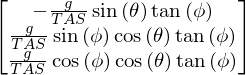

In [6]:
rot = tan(phi)*g/TAS
rotb = HEB.dot(np.vstack([0,0,rot]))
Matrix(rotb)

The gravity vector is represented in body coordinates as:
$$
a_g = HEB \begin{bmatrix} 0 \\ 0 \\ -g \end{bmatrix}
$$

Acceleration in body coordinates is given by:
$$ 
\boldsymbol{a_c} = HEB
\begin{bmatrix}
-g \tan(\phi) \sin(\psi) \\
g \tan(\phi) \cos(\psi) \\
0 \\
\end{bmatrix}
$$

Total acceleration is then given by:
$$
\boldsymbol{a} = \boldsymbol{a_c} + \boldsymbol{a_g}
$$

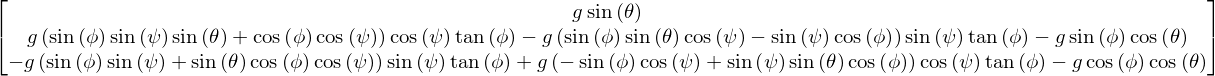

In [7]:
ag = HEB.dot(np.vstack([0,0,-g]))
ac = HEB.dot(np.vstack([-g*tan(phi)*sin(psi), g*tan(phi)*cos(psi), 0]))

ab = ac + ag
Matrix(ab)

We now have enough information to construct the state vector $x$ and calculate the corresponding Jacobian matrix.  The following calculates both and displays the non-zero values.

In [8]:
x = Matrix([p,q,r, 
            ab[0,0], ab[1,0], ab[2,0],
            phi + p*dt,
            theta + q*dt,
            psi + rot*dt,
            TAS + ax*dt,
            magxe, magze])
F = x.jacobian(statevars)

Just printing the non-zero values is a bit easier to inspect and convert to code:

In [10]:
for i in range(nstates):
    for j in range(nstates):
        tmp = simplify(F[i,j])
        if tmp != 0:
            print(f"F[{i},{j}] = {tmp}")

F[0,0] = 1
F[1,1] = 1
F[2,2] = 1
F[3,7] = g*cos(theta)
F[4,6] = g*(-cos(theta) + 1)*cos(phi)
F[4,7] = g*sin(phi)*sin(theta)
F[5,6] = g*(cos(theta) - 1 - 1/cos(phi)**2)*sin(phi)
F[5,7] = g*sin(theta)*cos(phi)
F[6,0] = dt
F[6,6] = 1
F[7,1] = dt
F[7,7] = 1
F[8,6] = dt*g/(TAS*cos(phi)**2)
F[8,8] = 1
F[8,9] = -dt*g*tan(phi)/TAS**2
F[9,3] = dt
F[9,9] = 1
F[10,10] = 1
F[11,11] = 1


This provides all the information necessary to complete the EKF predict step.  

Now we can perform a similar analysis for the update step.  Since body acceleration, rotation rates, and TAS are states in the EKF, the update step is trival -- $H$ is the identity matrix and the $h()$ function is a direct mapping of the sensors to the EKF states.  The magnetometer update is a bit more involved.  Earth's magnetic field vector is converted to body axes by multiplying by the rotation matrix.

$$ 
\boldsymbol{m_b} = 
HEB
\begin{bmatrix}
m_x \\ 0 \\ m_z
\end{bmatrix}
$$

$H$ is then deteremined by taking the Jacobian of this result:

In [14]:
mb = Matrix(HEB)*Matrix([magxe, 0, magze])
H = mb.jacobian(statevars)
for i in range(3):
    for j in range(len(statevars)):
        tmp = simplify(H[i,j])
        if tmp != 0:
            print(f"H[{i},{j}] = {tmp}")

H[0,7] = -magxe*sin(theta)*cos(psi) - magze*cos(theta)
H[0,8] = -magxe*sin(psi)*cos(theta)
H[0,10] = cos(psi)*cos(theta)
H[0,11] = -sin(theta)
H[1,6] = magxe*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)) + magze*cos(phi)*cos(theta)
H[1,7] = (magxe*cos(psi)*cos(theta) - magze*sin(theta))*sin(phi)
H[1,8] = -magxe*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi))
H[1,10] = sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)
H[1,11] = sin(phi)*cos(theta)
H[2,6] = -magxe*sin(phi)*sin(theta)*cos(psi) + magxe*sin(psi)*cos(phi) - magze*sin(phi)*cos(theta)
H[2,7] = (magxe*cos(psi)*cos(theta) - magze*sin(theta))*cos(phi)
H[2,8] = magxe*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))
H[2,10] = sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)
H[2,11] = cos(phi)*cos(theta)


## Compass caibration

### Hard Iron

This effect can be thought of as the offset of the magnetic vector tracing a perfect circle.  It is corrected by simplying subtracting a bias from the raw sensor values.

### Soft Iron

Soft iron is the distortion of that perfect circle.

A [generic model](https://www.vectornav.com/support/library/magnetometer) for compensation is

$$ 
M = 
\begin{bmatrix}
C_1 & C_2 & C_3 \\
C_4 & C_5 & C_6 \\
C_7 & C_8 & C_9 \\
\end{bmatrix} 
\begin{bmatrix}
H_x - C_{10} \\
H_y - C_{11} \\
H_z - C_{12} \\
\end{bmatrix}
$$